# Part 2: Image Classification with Deep Learning

## 2. Explain in your own words:

### a. Gradient Descent
Gradient Descent is an optimization algorithm used to minimize a loss function by iteratively moving in the direction of the steepest descent, as defined by the negative of the gradient. It updates model parameters (weights) by computing gradients and adjusting weights to reduce the error in predictions.

### b. List 3 regularization techniques and explain
1. **L1 Regularization (Lasso)**: Adds the absolute values of weights as a penalty to the loss function. It encourages sparsity by shrinking some weights to zero, effectively performing feature selection.
2. **L2 Regularization (Ridge)**: Adds the square of the weights as a penalty. This technique discourages large weights, making the model more robust and reducing overfitting.
3. **Dropout**: Temporarily drops a random set of neurons during training, preventing the model from becoming too reliant on certain features and reducing overfitting.

### c. Activation Functions
Activation functions introduce non-linearity into the neural network, enabling it to learn complex patterns. Common examples include:
- **ReLU (Rectified Linear Unit)**: Outputs zero for negative inputs and the input value for positive inputs.
- **Sigmoid**: Squashes input to a value between 0 and 1, useful for binary classification.

### d. Loss Function and Backpropagation
The **loss function** quantifies the difference between predicted and actual values, guiding the model's learning process. **Backpropagation** is the algorithm used to update weights by calculating the gradient of the loss function with respect to each weight, propagating the error backwards through the network, and using Gradient Descent to adjust the weights.

### e. Epochs, Iterations, and Batch Size
- **Epochs**: One complete pass through the entire training dataset.
- **Iterations**: One update of the model’s weights, equal to the number of batches required to process the entire dataset once (epochs).
- **Batch Size**: The number of training examples processed in one iteration before updating the model’s weights.

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

## 3. Visualize/summarize the data (12 points)

In [2]:
import pandas as pd

# Load the train.csv and test.csv files
train_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv')

# Display the first few rows of train_df
train_df.head()

image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket

In [4]:
# Display the first few rows of test_df
test_df.head()

image_ID
0  f5e13966e7.jpg
1  6674191b4e.jpg
2  91b5f8b7a9.jpg
3  393119b6d6.jpg
4  1ce5f81578.jpg

In [5]:
import os

# Define the path to the image folders
train_img_dir = '/kaggle/input/sports-image-classification/dataset/train'
test_img_dir = '/kaggle/input/sports-image-classification/dataset/test'

# Add the full image path to the dataframe
train_df['image_path'] = train_df['image_ID'].apply(lambda x: os.path.join(train_img_dir, x))
test_df['image_path'] = test_df['image_ID'].apply(lambda x: os.path.join(test_img_dir, x))

# Updated train DataFrame
train_df.head()

image_ID      label  \
0  7c225f7b61.jpg  Badminton   
1         b31.jpg  Badminton   
2  acb146546c.jpg  Badminton   
3  0e62f4d8f2.jpg  Badminton   
4  cfd2c28c74.jpg    Cricket   

                                          image_path  
0  /kaggle/input/sports-image-classification/data...  
1  /kaggle/input/sports-image-classification/data...  
2  /kaggle/input/sports-image-classification/data...  
3  /kaggle/input/sports-image-classification/data...  
4  /kaggle/input/sports-image-classification/data...

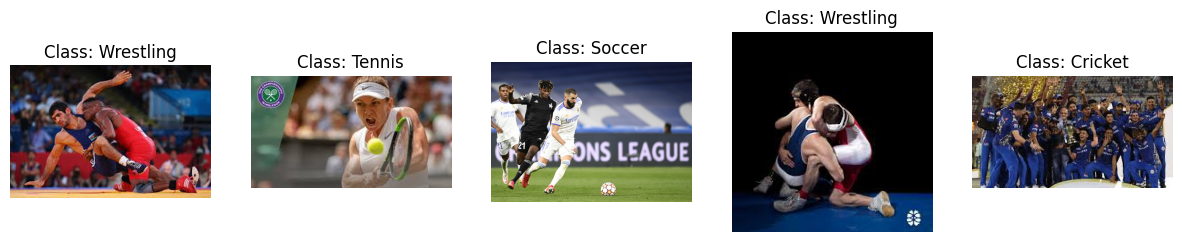

In [6]:
import matplotlib.pyplot as plt
import cv2

# Function to show sample images
def show_sample_images(df, num_samples=5):
    sample_df = df.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, (index, row) in enumerate(sample_df.iterrows()):
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {row['label']}")
        axes[i].axis('off')

    plt.show()

# Show 5 random sample images from the training set
show_sample_images(train_df, 5)

### a. Number of images in the training and testing set and number of classes in the target variable

In [6]:
# Number of images in the training and testing sets
num_train_images = len(train_df)
num_test_images = len(test_df)

print(f"Number of images in the training set: {num_train_images}")
print(f"Number of images in the testing set: {num_test_images}")

Number of images in the training set: 8227
Number of images in the testing set: 2056


In [7]:
# Number of unique classes in the training set
num_classes = train_df['label'].nunique()

print(f"Number of classes in the target variable: {num_classes}")

Number of classes in the target variable: 7


### b. Number of images per class

In [8]:
# Number of images per class
images_per_class = train_df['label'].value_counts()

print("Number of images per class:")
images_per_class

Number of images per class:


label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64

### c. Number of pixels in the first 2 images of each class (Height and width individually)

In [9]:
from PIL import Image
import os

# Function to get image dimensions (height and width)
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

# Get the first 2 images per class and their dimensions
first_2_images_dimensions = {}

for label in train_df['label'].unique():
    # Get the first 2 images for each class
    first_2_images = train_df[train_df['label'] == label].head(2)

    dimensions = []
    for idx, row in first_2_images.iterrows():
        img_path = row['image_path']
        width, height = get_image_dimensions(img_path)
        dimensions.append((width, height))

    first_2_images_dimensions[label] = dimensions

# Print the dimensions of the first 2 images for each class
for label, dims in first_2_images_dimensions.items():
    print(f"\nClass: {label}")
    for i, (width, height) in enumerate(dims):
        print(f"  Image {i + 1}: Width = {width}, Height = {height}")


Class: Badminton
  Image 1: Width = 380, Height = 285
  Image 2: Width = 268, Height = 172

Class: Cricket
  Image 1: Width = 1200, Height = 900
  Image 2: Width = 2048, Height = 1152

Class: Tennis
  Image 1: Width = 299, Height = 168
  Image 2: Width = 300, Height = 168

Class: Swimming
  Image 1: Width = 259, Height = 194
  Image 2: Width = 1280, Height = 720

Class: Soccer
  Image 1: Width = 300, Height = 168
  Image 2: Width = 268, Height = 188

Class: Wrestling
  Image 1: Width = 1400, Height = 788
  Image 2: Width = 1024, Height = 576

Class: Karate
  Image 1: Width = 300, Height = 168
  Image 2: Width = 275, Height = 183


### d. Display at least 3 images of each class

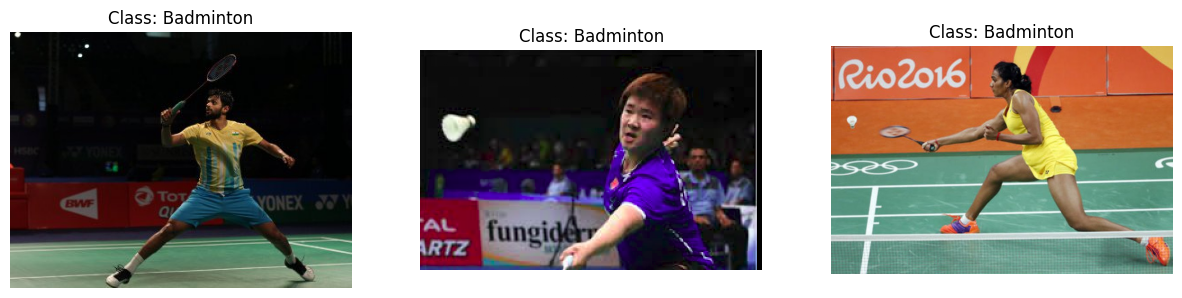

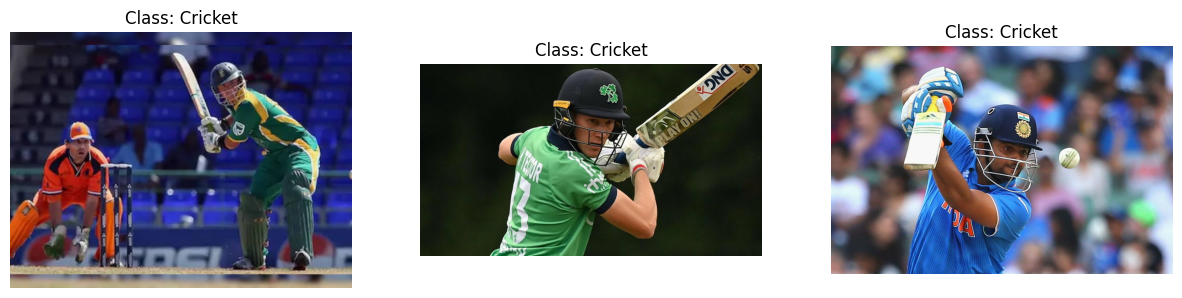

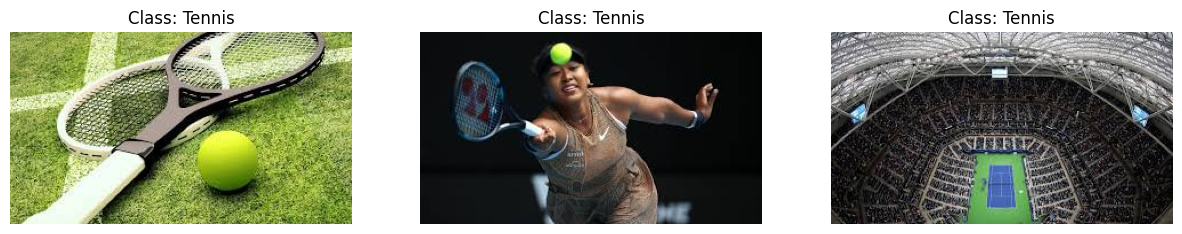

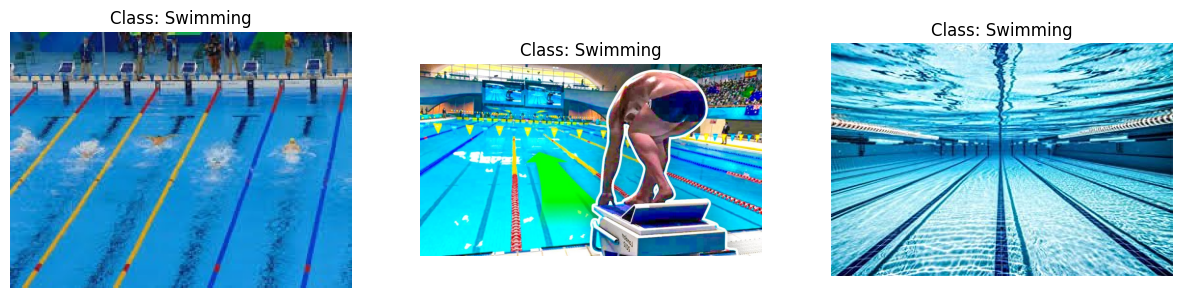

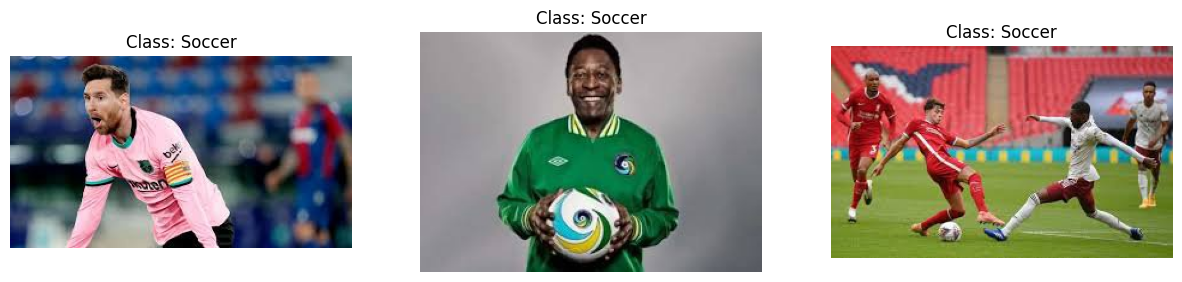

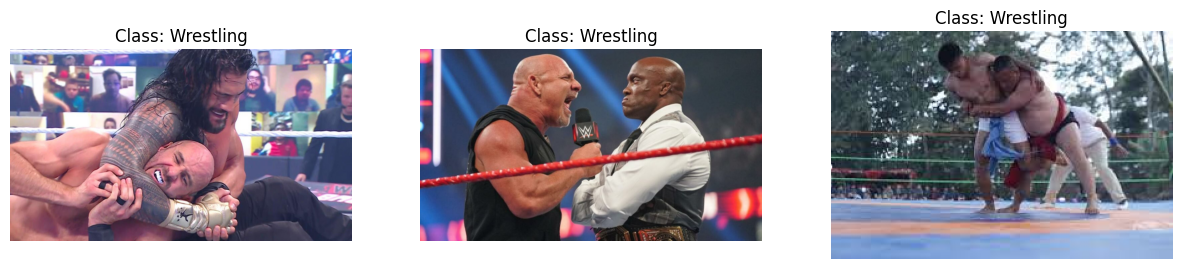

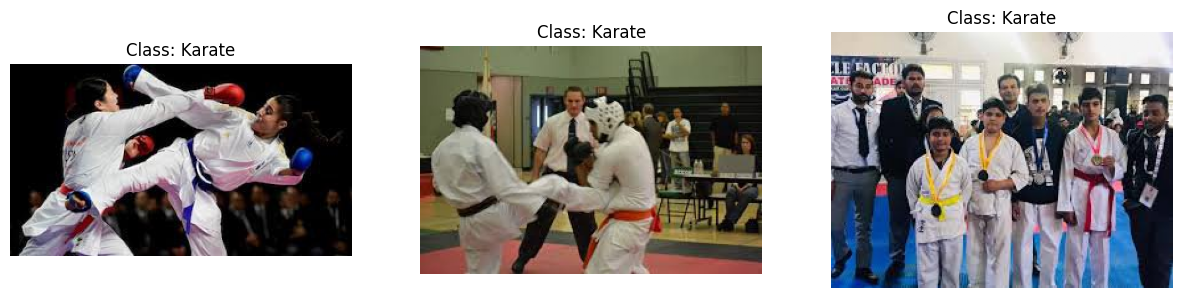

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

# Define a function to display images
def show_images(images, labels, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        img = img.permute(1, 2, 0)  # Change channel order for displaying
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')
    plt.show()

# Create a dictionary that maps label names to the images
class_to_images = {}

for label in train_df['label'].unique():
    class_to_images[label] = train_df[train_df['label'] == label].head(3)  # Get first 3 images per class

# Display 3 images from each class
for label, images_df in class_to_images.items():
    images = []
    labels = []
    for idx, row in images_df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = transforms.ToTensor()(img)
        images.append(img)
        labels.append(label)
    show_images(images, labels, num_images=3)

In [11]:
# Dataframe Labels
class_to_idx = {
    'Cricket': 0,
    'Wrestling': 1,
    'Tennis': 2,
    'Badminton': 3,
    'Soccer': 4,
    'Swimming': 5,
    'Karate': 6
}

# Convert string labels to numerical labels using the class_to_idx mapping
train_df['label'] = train_df['label'].map(class_to_idx)

# Check if any label was not mapped correctly
print(train_df['label'].isna().sum())  # Should print 0 if all labels are mapped correctly

0


### e. Apply data augmentation and other image preprocessing and plot the sample of processed images.

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define custom Dataset for loading images with augmentations
class AugmentedSportsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
        label = self.dataframe.iloc[idx]['label']  # Label should be already numeric

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
import torchvision.transforms as transforms

# Define the image transformations (augmentations)
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()  # Convert the image to tensor
])

# Create a dataset with data augmentation applied
augmented_train_dataset = AugmentedSportsDataset(train_df, transform=data_augmentation_transform)

# Create a DataLoader to load augmented images in batches
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)

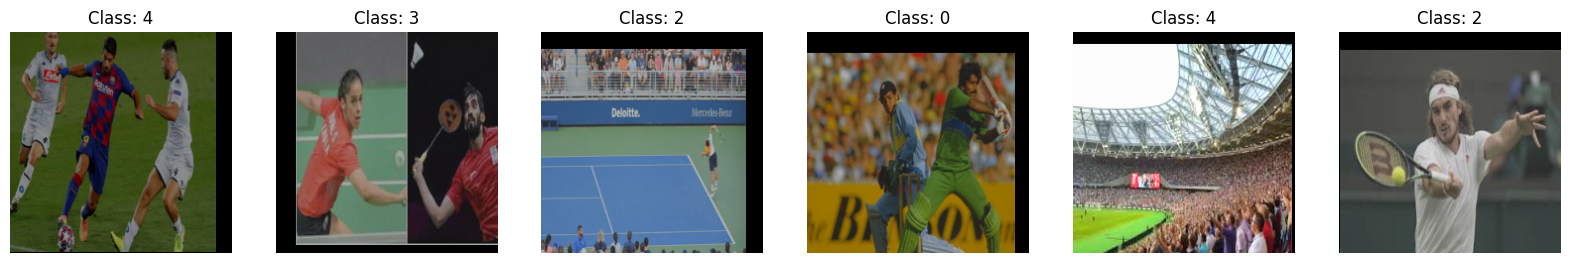

In [14]:
# Function to display a batch of augmented images
def show_augmented_batch(images, labels, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # Change channel order for displaying
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Get a batch of augmented images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show a few augmented images
show_augmented_batch(images, labels, num_images=6)

# 4. Train a Neural Network

### Train-test split

In [8]:
train_data = pd.read_csv('/kaggle/input/sports-image-classification/dataset/train.csv') 
test_data = pd.read_csv('/kaggle/input/sports-image-classification/dataset/test.csv')

# Split the train data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

### Defining Dataset Class for Images


In [6]:
class SportsDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Image filename
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')  # Open image

        label = self.dataframe.iloc[idx, 1]  # Image label
        label = label_to_index[label]  # Convert label to index

        if self.transform:
            image = self.transform(image)
        
        return image, label


### Image Transformations


In [7]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


### Mapping images to their Labels

In [8]:
# Define label to index mapping
label_to_index = {label: idx for idx, label in enumerate(train_data['label'].unique())}

# Define datasets
train_dataset = SportsDataset(train_df, 'Sports_Image_Classification/dataset/train', transform=train_transform)
val_dataset = SportsDataset(val_df, 'Sports_Image_Classification/dataset/train', transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Train Function

In [50]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import time

# Training function
def train_model(model, train_loader, val_loader, optimizer, loss_fn, num_epochs=10, device='cuda'):
    # Move the model to the appropriate device (GPU or CPU)
    model.to(device)
    
    # Track training and validation metrics
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
    start_time = time.time()
    print(f"Starting execution at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track training loss
            train_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for metrics calculation
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        # Calculate average training loss, accuracy, and F1 score
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Track validation loss
                val_loss += loss.item() * images.size(0)
                
                # Store predictions and labels for metrics calculation
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss, accuracy, and F1 score
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        # Save metrics for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Print the results for this epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')

    end_time = time.time()
    duration = (end_time - start_time) / 60
    print(f"Execution completed at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(end_time))}")
    print(f"Duration: {duration:.2f} minutes")

    return history

In [51]:
# Function to plot the metrics
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plotting Loss
    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # F1 Score Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# a. Decide the number of layers and neurons in each layer

In each model, we used different configurations of layers.
- Model 1: 
  - 2 convolutional layers with 32 and 64 neurons respectively.
  - Fully connected layer with 512 neurons and 7 output classes.

- Model 2:
  - 3 convolutional layers with 32, 64, and 128 neurons.
  - Fully connected layer with 512 neurons and 7 output classes.

# Model 1

### ReLU Activation, L2 Regularization, Cross-Entropy Loss, Adam Optimizer

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Placeholder for the fully connected layer, set after knowing the flattened size
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        """ Pass a dummy input to calculate the flattened size dynamically. """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        # Initialize fc1 based on the dynamically computed flatten size
        dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = Model1()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# L2 regularization is applied via the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


In [12]:
# Train the model
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

Starting execution at 2024-10-24 02:13:07

Epoch [1/20], Train Loss: 1.9288, Train Acc: 0.3828, Train F1: 0.3378, Val Loss: 1.3232, Val Acc: 0.5213, Val F1: 0.4620

Epoch [2/20], Train Loss: 1.3570, Train Acc: 0.5043, Train F1: 0.4521, Val Loss: 1.3031, Val Acc: 0.5128, Val F1: 0.4493

Epoch [3/20], Train Loss: 1.3004, Train Acc: 0.5172, Train F1: 0.4665, Val Loss: 1.2514, Val Acc: 0.5298, Val F1: 0.4793

Epoch [4/20], Train Loss: 1.2889, Train Acc: 0.5195, Train F1: 0.4673, Val Loss: 1.2276, Val Acc: 0.5365, Val F1: 0.4830

Epoch [5/20], Train Loss: 1.2579, Train Acc: 0.5362, Train F1: 0.4914, Val Loss: 1.2094, Val Acc: 0.5516, Val F1: 0.5064

Epoch [6/20], Train Loss: 1.2350, Train Acc: 0.5396, Train F1: 0.4953, Val Loss: 1.2224, Val Acc: 0.5395, Val F1: 0.4864

Epoch [7/20], Train Loss: 1.2242, Train Acc: 0.5519, Train F1: 0.5150, Val Loss: 1.2856, Val Acc: 0.5097, Val F1: 0.4518

Epoch [8/20], Train Loss: 1.1877, Train Acc: 0.5596, Train F1: 0.5185, Val Loss: 1.1666, Val Acc: 0.563

# Model 2
### Leaky ReLU Activation, Dropout Regularization, Cross-Entropy Loss, SGD Optimizer

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization layer after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # New convolutional layer
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization layer after conv3
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Placeholder for the fully connected layer, set after knowing the flattened size
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        """ Pass a dummy input to calculate the flattened size dynamically. """
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Additional convolution layer
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        # Initialize fc1 based on the dynamically computed flatten size
        dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Pass through additional layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = Model1()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# L2 regularization is applied via the optimizer (weight_decay parameter)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-24 02:38:44

Epoch [1/20], Train Loss: 2.9714, Train Acc: 0.4704, Train F1: 0.4563, Val Loss: 1.2520, Val Acc: 0.5316, Val F1: 0.5403

Epoch [2/20], Train Loss: 1.1523, Train Acc: 0.5800, Train F1: 0.5731, Val Loss: 0.9622, Val Acc: 0.6464, Val F1: 0.6379

Epoch [3/20], Train Loss: 1.1018, Train Acc: 0.6177, Train F1: 0.6094, Val Loss: 1.0081, Val Acc: 0.6434, Val F1: 0.6312

Epoch [4/20], Train Loss: 1.0026, Train Acc: 0.6475, Train F1: 0.6355, Val Loss: 1.0085, Val Acc: 0.6628, Val F1: 0.6531

Epoch [5/20], Train Loss: 0.9363, Train Acc: 0.6674, Train F1: 0.6595, Val Loss: 1.0149, Val Acc: 0.6373, Val F1: 0.6104

Epoch [6/20], Train Loss: 0.9143, Train Acc: 0.6858, Train F1: 0.6825, Val Loss: 0.9894, Val Acc: 0.6592, Val F1: 0.6075

Epoch [7/20], Train Loss: 0.8645, Train Acc: 0.6997, Train F1: 0.6921, Val Loss: 0.8191, Val Acc: 0.7114, Val F1: 0.6977

Epoch [8/20], Train Loss: 0.8351, Train Acc: 0.7052, Train F1: 0.7018, Val Loss: 0.9170, Val Acc: 0.676

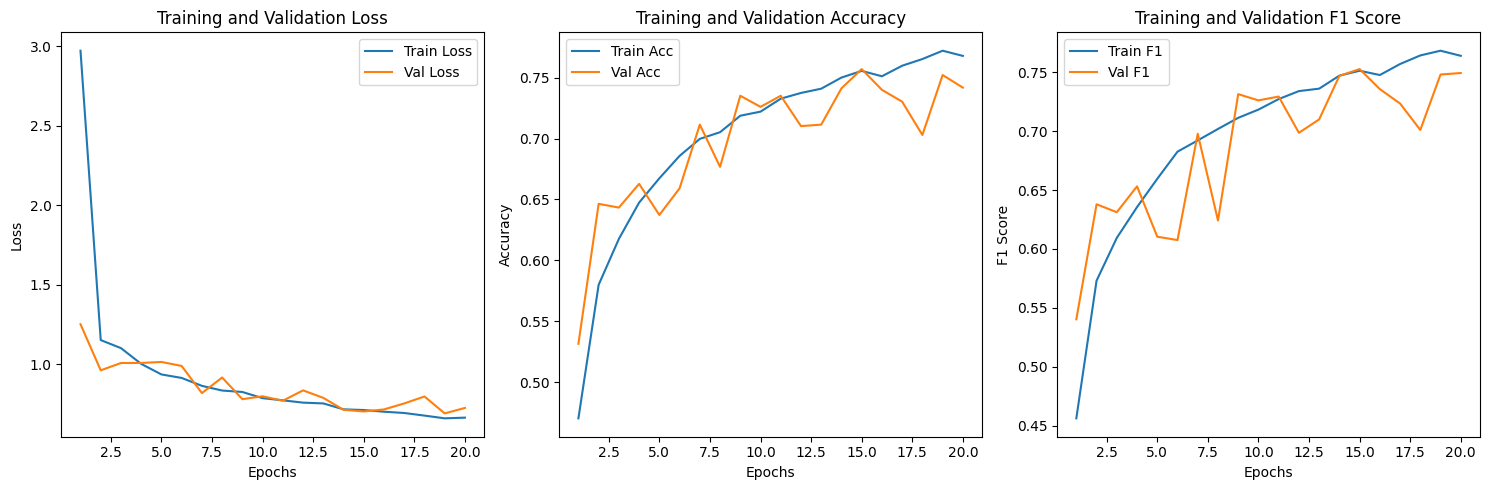

In [14]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

### a. Inference: Deciding the Number of Layers and Neurons in Each Layer
We experimented with two different models using various configurations of layers and neurons to find the optimal architecture:

#### **Model 1:**
- **Convolutional Layers**: 
  - Conv1: 32 filters, kernel size 3x3, padding 1
  - Conv2: 64 filters, kernel size 3x3, padding 1

#### **Model 2**:
- **Convolutional Layers**: 
  - Conv1: 32 filters, kernel size 3x3, padding 1, followed by Batch Normalization
  - Conv2: 64 filters, kernel size 3x3, padding 1, followed by Batch Normalization
  - Conv3: 128 filters, kernel size 3x3, padding 1, followed by Batch Normalization (additional convolutional layer for better feature extraction)

#### **Common Configuration** (for both models):
- **Pooling Layer**: Max pooling with 2x2 window after each convolutional layer.
- **Fully Connected Layers**:
  - FC1: Dynamically computed number of neurons in the first fully connected layer based on the input image size, with a final fully connected layer of 512 neurons.
  - FC2: 7 neurons for 7 output classes.

#### **Performance Comparison**:
- **Model 1**: After 20 epochs, the best validation accuracy was **61.30%** with a validation F1 score of **58.23%**.
- **Model 2**: With an additional convolutional layer, Model 2 achieved a better validation accuracy of **75.27%** and a validation F1 score of **74.92%**.

These results show that Model 2, with its deeper architecture and additional convolutional layer, led to improved performance metrics compared to Model 1.

# Model 3

### Leaky ReLU Activation, Dropout Regularization, Cross-Entropy Loss, SGD Optimizer

In [22]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)

    def _get_flatten_size(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv3(x), negative_slope=0.01))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv3(x), negative_slope=0.01))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Optimizer with dropout regularization
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-25 00:40:09

Epoch [1/20], Train Loss: 1.6222, Train Acc: 0.4391, Train F1: 0.4134, Val Loss: 1.2144, Val Acc: 0.5601, Val F1: 0.5414

Epoch [2/20], Train Loss: 1.3190, Train Acc: 0.5107, Train F1: 0.5036, Val Loss: 1.0340, Val Acc: 0.6300, Val F1: 0.6248

Epoch [3/20], Train Loss: 1.2484, Train Acc: 0.5340, Train F1: 0.5274, Val Loss: 1.0200, Val Acc: 0.6361, Val F1: 0.6386

Epoch [4/20], Train Loss: 1.1791, Train Acc: 0.5756, Train F1: 0.5777, Val Loss: 0.9588, Val Acc: 0.6592, Val F1: 0.6636

Epoch [5/20], Train Loss: 1.1277, Train Acc: 0.5820, Train F1: 0.5785, Val Loss: 0.9505, Val Acc: 0.6719, Val F1: 0.6736

Epoch [6/20], Train Loss: 1.0963, Train Acc: 0.5954, Train F1: 0.5910, Val Loss: 0.9409, Val Acc: 0.6391, Val F1: 0.6356

Epoch [7/20], Train Loss: 1.0588, Train Acc: 0.6043, Train F1: 0.6054, Val Loss: 0.9210, Val Acc: 0.6567, Val F1: 0.6518

Epoch [8/20], Train Loss: 1.0363, Train Acc: 0.6128, Train F1: 0.6157, Val Loss: 0.8355, Val Acc: 0.704

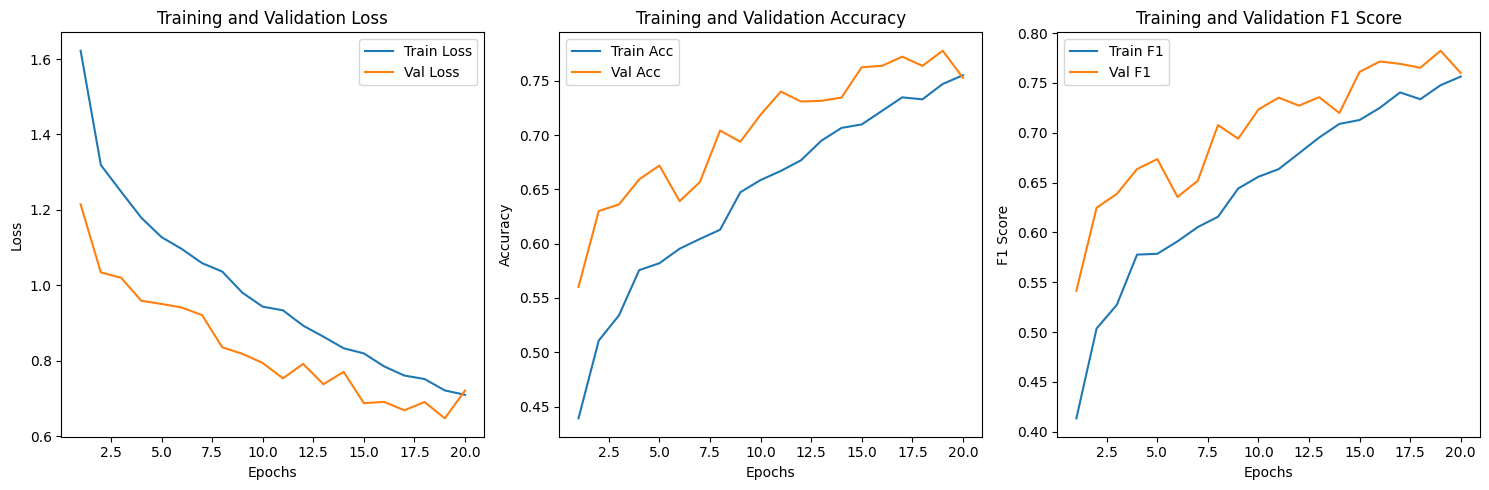

In [23]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

In [24]:
# Function to save the model's weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

# Example usage: Save model weights after training
save_model(model, "model2_weights.pth")


Model weights saved to model2_weights.pth


# Model 4
### Sigmoid Activation, Dropout Regularization, Cross-Entropy Loss, Adam Optimizer

In [52]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)

    def _get_flatten_size(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = self.pool(F.sigmoid(self.conv3(x)))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = self.pool(F.sigmoid(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Optimizer with dropout regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Loss function
criterion = nn.CrossEntropyLoss()



Starting execution at 2024-10-25 22:00:53

Epoch [1/25], Train Loss: 1.0993, Train Acc: 0.6083, Train F1: 0.5956, Val Loss: 0.8744, Val Acc: 0.6987, Val F1: 0.6914

Epoch [2/25], Train Loss: 1.0307, Train Acc: 0.6397, Train F1: 0.6269, Val Loss: 0.8828, Val Acc: 0.6762, Val F1: 0.6724

Epoch [3/25], Train Loss: 0.9498, Train Acc: 0.6686, Train F1: 0.6580, Val Loss: 0.7529, Val Acc: 0.7430, Val F1: 0.7428

Epoch [4/25], Train Loss: 0.9149, Train Acc: 0.6853, Train F1: 0.6755, Val Loss: 0.7528, Val Acc: 0.7448, Val F1: 0.7372

Epoch [5/25], Train Loss: 0.8483, Train Acc: 0.7041, Train F1: 0.6948, Val Loss: 0.8457, Val Acc: 0.7102, Val F1: 0.7005

Epoch [6/25], Train Loss: 0.8081, Train Acc: 0.7165, Train F1: 0.7093, Val Loss: 0.6905, Val Acc: 0.7552, Val F1: 0.7484

Epoch [7/25], Train Loss: 0.7728, Train Acc: 0.7333, Train F1: 0.7307, Val Loss: 0.6449, Val Acc: 0.7697, Val F1: 0.7663

Epoch [8/25], Train Loss: 0.7119, Train Acc: 0.7513, Train F1: 0.7502, Val Loss: 0.5837, Val Acc: 0.790

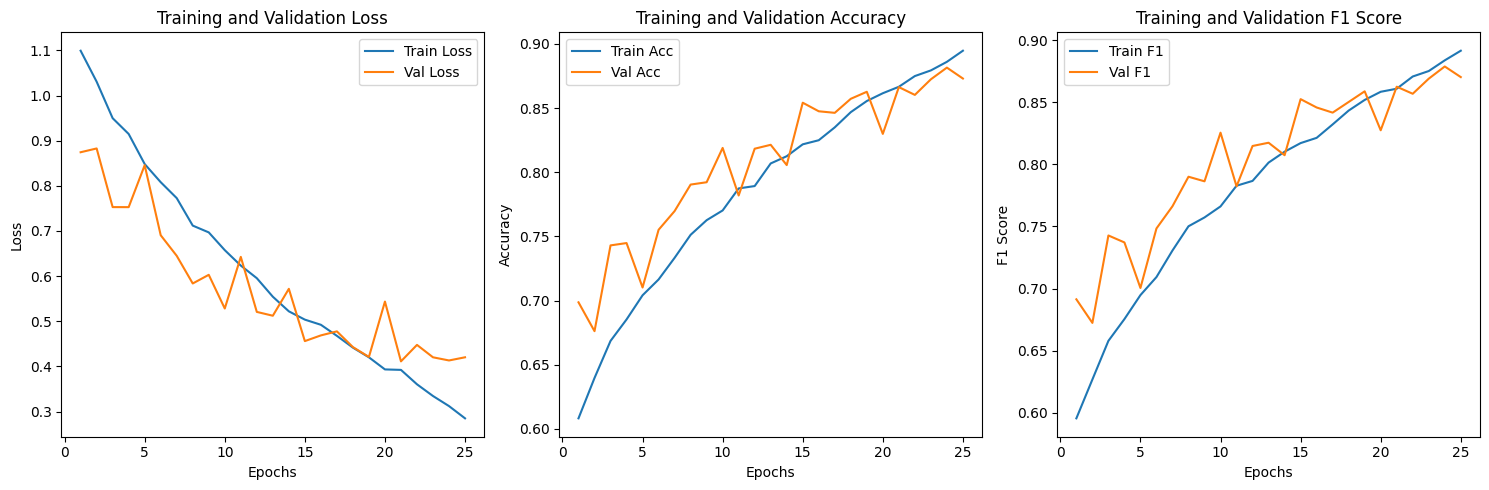

In [53]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=25, device='cuda')

# Plot the metrics after training
plot_metrics(history)

In [54]:
# Function to save the model's weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

# Example usage: Save model weights after training
save_model(model, "model3_weights_25epochs.pth")


Model weights saved to model3_weights_25epochs.pth


# Model 5
###  Tanh Activation, L2 Regularization, Cross-Entropy Loss, RMSprop Optimizer

In [19]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)

    def _get_flatten_size(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# Optimizer with L2 regularization
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-24 03:56:08

Epoch [1/20], Train Loss: 0.3027, Train Acc: 0.9067, Train F1: 0.9086, Val Loss: 0.6847, Val Acc: 0.7758, Val F1: 0.7748

Epoch [2/20], Train Loss: 0.2856, Train Acc: 0.9023, Train F1: 0.9018, Val Loss: 0.6766, Val Acc: 0.7886, Val F1: 0.7781

Epoch [3/20], Train Loss: 0.3249, Train Acc: 0.8918, Train F1: 0.8889, Val Loss: 0.6184, Val Acc: 0.8080, Val F1: 0.8053

Epoch [4/20], Train Loss: 0.3492, Train Acc: 0.8822, Train F1: 0.8826, Val Loss: 0.5563, Val Acc: 0.8269, Val F1: 0.8203

Epoch [5/20], Train Loss: 0.3430, Train Acc: 0.8803, Train F1: 0.8790, Val Loss: 0.5052, Val Acc: 0.8317, Val F1: 0.8308

Epoch [6/20], Train Loss: 0.3552, Train Acc: 0.8737, Train F1: 0.8729, Val Loss: 0.7123, Val Acc: 0.7813, Val F1: 0.7712

Epoch [7/20], Train Loss: 0.3743, Train Acc: 0.8751, Train F1: 0.8751, Val Loss: 0.5798, Val Acc: 0.8032, Val F1: 0.8055

Epoch [8/20], Train Loss: 0.3744, Train Acc: 0.8680, Train F1: 0.8657, Val Loss: 0.5813, Val Acc: 0.805

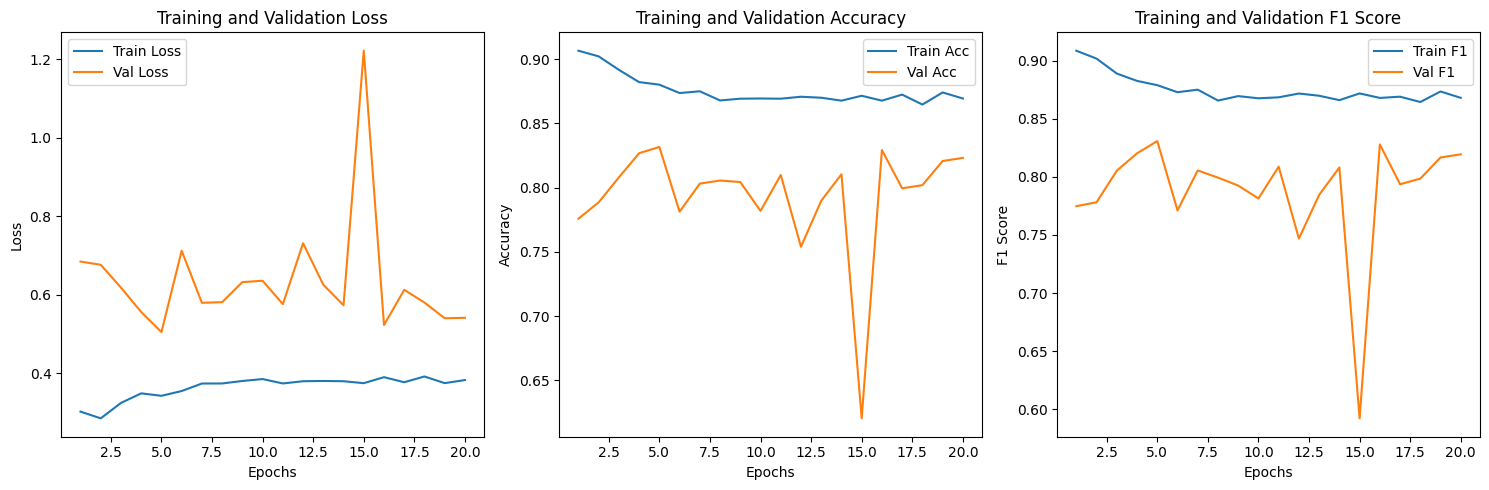

In [20]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

# Model 6
### ReLU Activation, Batch Normalization, Cross-Entropy Loss, Adam Optimizer

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Model5(nn.Module):
    def __init__(self):
        super(Model5, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization layer after conv1
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization layer after conv2
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization layer after conv3
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Placeholder for fully connected layers
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        """ Pass a dummy input to calculate the flattened size dynamically. """
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        # Initialize fc1 based on the dynamically computed flatten size
        dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = Model5()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer with L2 regularization (weight_decay parameter)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-24 04:22:04

Epoch [1/20], Train Loss: 2.4371, Train Acc: 0.4805, Train F1: 0.4608, Val Loss: 1.1019, Val Acc: 0.5948, Val F1: 0.5810

Epoch [2/20], Train Loss: 1.0969, Train Acc: 0.6115, Train F1: 0.6031, Val Loss: 0.9255, Val Acc: 0.6701, Val F1: 0.6623

Epoch [3/20], Train Loss: 0.9456, Train Acc: 0.6674, Train F1: 0.6542, Val Loss: 1.0233, Val Acc: 0.6306, Val F1: 0.6132

Epoch [4/20], Train Loss: 0.8606, Train Acc: 0.6931, Train F1: 0.6856, Val Loss: 0.8896, Val Acc: 0.6798, Val F1: 0.6704

Epoch [5/20], Train Loss: 0.7726, Train Acc: 0.7268, Train F1: 0.7198, Val Loss: 0.7300, Val Acc: 0.7448, Val F1: 0.7394

Epoch [6/20], Train Loss: 0.7299, Train Acc: 0.7394, Train F1: 0.7323, Val Loss: 0.8966, Val Acc: 0.6944, Val F1: 0.6685

Epoch [7/20], Train Loss: 0.6641, Train Acc: 0.7634, Train F1: 0.7625, Val Loss: 0.7475, Val Acc: 0.7448, Val F1: 0.7283

Epoch [8/20], Train Loss: 0.6346, Train Acc: 0.7778, Train F1: 0.7763, Val Loss: 0.6519, Val Acc: 0.775

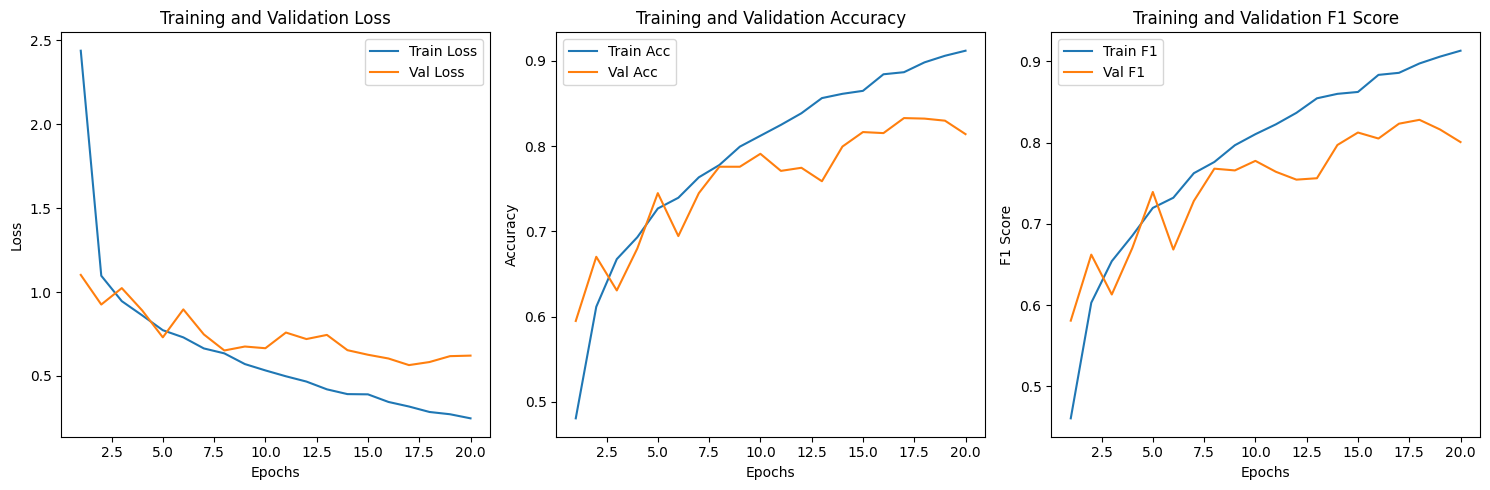

In [22]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

# Model 7
### Mish Activation, Batch Normalization, L2 Regularization, Adam Optimizer

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Model6(nn.Module):
    def __init__(self):
        super(Model6, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        x = self.pool(F.mish(self.bn1(self.conv1(x))))
        x = self.pool(F.mish(self.bn2(self.conv2(x))))
        x = self.pool(F.mish(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.mish(self.bn1(self.conv1(x))))
        x = self.pool(F.mish(self.bn2(self.conv2(x))))
        x = self.pool(F.mish(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.mish(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = Model6()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# L2 regularization is applied via the optimizer (weight_decay parameter)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Loss function
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-24 04:48:04

Epoch [1/20], Train Loss: 2.0900, Train Acc: 0.5121, Train F1: 0.5060, Val Loss: 1.1857, Val Acc: 0.5808, Val F1: 0.5822

Epoch [2/20], Train Loss: 1.1825, Train Acc: 0.5925, Train F1: 0.5856, Val Loss: 1.1721, Val Acc: 0.5778, Val F1: 0.5469

Epoch [3/20], Train Loss: 1.1140, Train Acc: 0.6206, Train F1: 0.6126, Val Loss: 1.1166, Val Acc: 0.5814, Val F1: 0.5757

Epoch [4/20], Train Loss: 1.0098, Train Acc: 0.6472, Train F1: 0.6403, Val Loss: 1.2283, Val Acc: 0.5559, Val F1: 0.5519

Epoch [5/20], Train Loss: 0.9778, Train Acc: 0.6543, Train F1: 0.6440, Val Loss: 0.9696, Val Acc: 0.6592, Val F1: 0.6213

Epoch [6/20], Train Loss: 0.9207, Train Acc: 0.6762, Train F1: 0.6700, Val Loss: 0.9494, Val Acc: 0.6610, Val F1: 0.6513

Epoch [7/20], Train Loss: 0.9132, Train Acc: 0.6849, Train F1: 0.6787, Val Loss: 0.9422, Val Acc: 0.6677, Val F1: 0.6538

Epoch [8/20], Train Loss: 0.8914, Train Acc: 0.6845, Train F1: 0.6801, Val Loss: 0.8375, Val Acc: 0.702

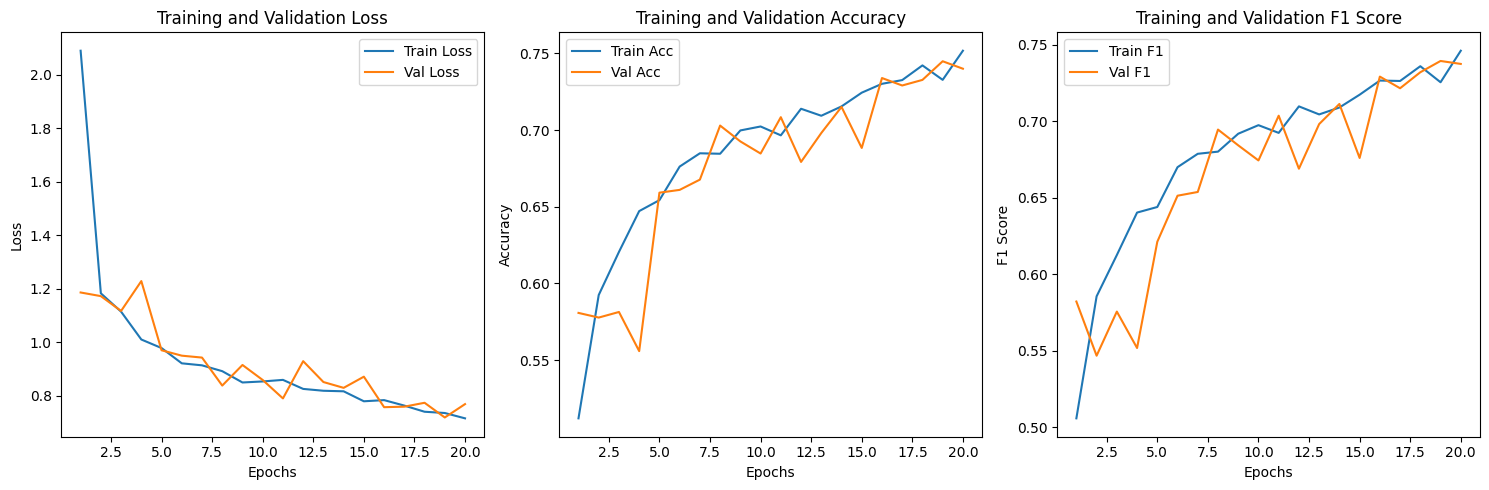

In [24]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

# Model 8

### ELU Activation, L1 Regularization, Cross-Entropy Loss, SGD Optimizer

In [25]:
class Model7(nn.Module):
    def __init__(self):
        super(Model7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = Model7()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# L1 regularization is applied via the optimizer (L1 decay through regularization parameter)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Loss function
criterion = nn.CrossEntropyLoss()


Starting execution at 2024-10-24 05:13:33

Epoch [1/20], Train Loss: 1.4078, Train Acc: 0.4771, Train F1: 0.4604, Val Loss: 1.3160, Val Acc: 0.5389, Val F1: 0.5219

Epoch [2/20], Train Loss: 1.1592, Train Acc: 0.5864, Train F1: 0.5763, Val Loss: 0.9921, Val Acc: 0.6324, Val F1: 0.6278

Epoch [3/20], Train Loss: 1.0570, Train Acc: 0.6288, Train F1: 0.6180, Val Loss: 1.2963, Val Acc: 0.5608, Val F1: 0.4795

Epoch [4/20], Train Loss: 1.0023, Train Acc: 0.6438, Train F1: 0.6344, Val Loss: 1.0648, Val Acc: 0.6215, Val F1: 0.6148

Epoch [5/20], Train Loss: 0.9300, Train Acc: 0.6716, Train F1: 0.6617, Val Loss: 0.9466, Val Acc: 0.6847, Val F1: 0.6772

Epoch [6/20], Train Loss: 0.8960, Train Acc: 0.6868, Train F1: 0.6781, Val Loss: 0.9097, Val Acc: 0.6908, Val F1: 0.6803

Epoch [7/20], Train Loss: 0.8545, Train Acc: 0.7029, Train F1: 0.6967, Val Loss: 0.9915, Val Acc: 0.6738, Val F1: 0.6659

Epoch [8/20], Train Loss: 0.8123, Train Acc: 0.7137, Train F1: 0.7056, Val Loss: 1.1354, Val Acc: 0.636

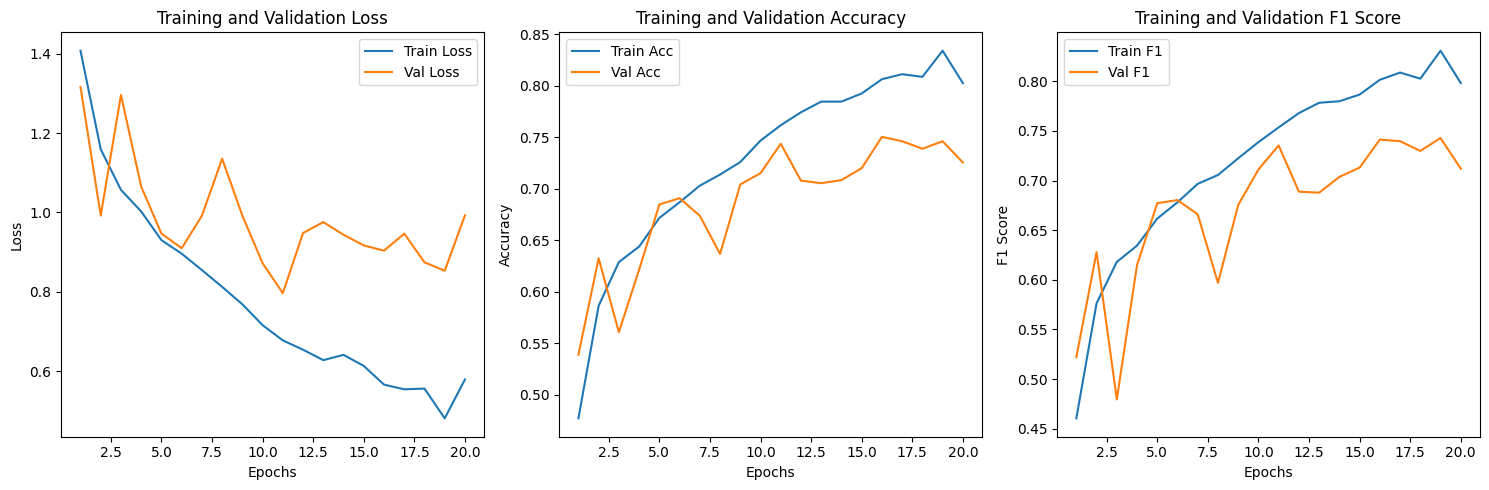

In [26]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

# Model 9 

### Focal Loss

In [28]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)  # Standard cross-entropy
        pt = torch.exp(-ce_loss)  # Compute the probability for the true class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [29]:
import torch.nn as nn
import torch.nn.functional as F

class ModelFocal(nn.Module):
    def __init__(self):
        super(ModelFocal, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = None  # Set dynamically based on input shape
        self.fc2 = nn.Linear(512, 7)  # 7 output classes

    def _get_flatten_size(self, x):
        """ Calculate the flattened size after passing through convolutional layers. """
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the custom model
model = ModelFocal()

# Dynamically set the size for fc1 based on the input shape (e.g., (3, 150, 150))
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: Focal Loss
criterion = FocalLoss(gamma=2.0)  # You can experiment with gamma values


Starting execution at 2024-10-25 01:30:21

Epoch [1/20], Train Loss: 2.1691, Train Acc: 0.4887, Train F1: 0.4744, Val Loss: 0.5500, Val Acc: 0.5826, Val F1: 0.5180

Epoch [2/20], Train Loss: 0.4190, Train Acc: 0.6426, Train F1: 0.6332, Val Loss: 0.4877, Val Acc: 0.6100, Val F1: 0.6003

Epoch [3/20], Train Loss: 0.3191, Train Acc: 0.6874, Train F1: 0.6794, Val Loss: 0.2918, Val Acc: 0.6914, Val F1: 0.6868

Epoch [4/20], Train Loss: 0.2736, Train Acc: 0.7075, Train F1: 0.7027, Val Loss: 0.3221, Val Acc: 0.6786, Val F1: 0.6655

Epoch [5/20], Train Loss: 0.2400, Train Acc: 0.7218, Train F1: 0.7187, Val Loss: 0.2737, Val Acc: 0.7132, Val F1: 0.7065

Epoch [6/20], Train Loss: 0.1823, Train Acc: 0.7579, Train F1: 0.7567, Val Loss: 0.2364, Val Acc: 0.7327, Val F1: 0.7270

Epoch [7/20], Train Loss: 0.1617, Train Acc: 0.7736, Train F1: 0.7714, Val Loss: 0.2189, Val Acc: 0.7345, Val F1: 0.7227

Epoch [8/20], Train Loss: 0.1393, Train Acc: 0.7806, Train F1: 0.7786, Val Loss: 0.2035, Val Acc: 0.749

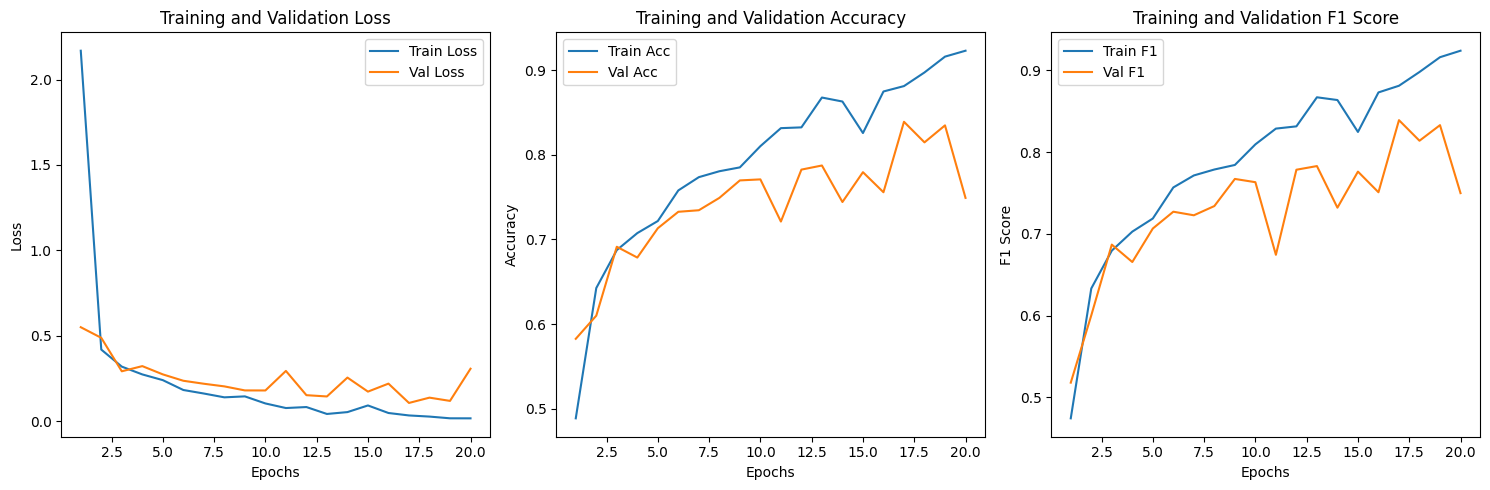

In [30]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=20, device='cuda')

# Plot the metrics after training
plot_metrics(history)

In [31]:
# Function to save the model's weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

# Example usage: Save model weights after training
save_model(model, "model9_weights.pth")


Model weights saved to model9_weights.pth


# Final Model: Improved Model 3

We finalized **Model 3** as our best-performing model based on its accuracy and efficiency across experiments. To further enhance its performance, we introduced additional improvements, including an extra convolutional layer and increased the number of filters. This modified model was trained for **30 epochs** and yielded the following results:

Starting execution at 2024-10-25 21:00:25

- **Epoch 1**: Train Loss: 4.7181, Train Acc: 0.3267, Train F1: 0.3097, Val Loss: 1.5683, Val Acc: 0.4313, Val F1: 0.3467
- **Epoch 10**: Train Loss: 1.1660, Train Acc: 0.6897, Train F1: 0.6775, Val Loss: 1.0219, Val Acc: 0.7400, Val F1: 0.7361
- **Epoch 20**: Train Loss: 1.1024, Train Acc: 0.7204, Train F1: 0.7110, Val Loss: 0.9941, Val Acc: 0.7527, Val F1: 0.7478
- **Epoch 30**: Train Loss: 1.0997, Train Acc: 0.7239, Train F1: 0.7136, Val Loss: 0.9918, Val Acc: 0.7533, Val F1: 0.7488

Execution completed at 2024-10-25 21:38:38  
Duration: 38.22 minutes

The model demonstrated strong validation performance, with consistent improvements in validation accuracy and F1 score across epochs.

In [2]:
class ImprovedModel3(nn.Module):
    def __init__(self):
        super(ImprovedModel3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 7)

    def _get_flatten_size(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Apply extra layer
        return x.view(x.size(0), -1).size(1)

    def initialize_fc1(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        flatten_size = self._get_flatten_size(dummy_input)
        self.fc1 = nn.Linear(flatten_size, 512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


NameError: name 'nn' is not defined

### Training Function for Model 3

In [46]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score

def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, num_epochs=10, device='cuda'):
    # Move the model to the appropriate device (GPU or CPU)
    model.to(device)
    
    # Track training and validation metrics
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}
    start_time = time.time()
    print(f"Starting execution at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Track training loss
            train_loss += loss.item() * images.size(0)

            # Store predictions and labels for metrics calculation
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        # Calculate average training loss, accuracy, and F1 score
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                # Track validation loss
                val_loss += loss.item() * images.size(0)

                # Store predictions and labels for metrics calculation
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate average validation loss, accuracy, and F1 score
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='macro')

        # Save metrics for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        # Step the learning rate scheduler
        scheduler.step()

        # Print the results for this epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
    end_time = time.time()
    duration = (end_time - start_time) / 60
    print(f"Execution completed at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(end_time))}")
    print(f"Duration: {duration:.2f} minutes")
    return history


In [47]:
# Define the improved model
model = ImprovedModel3()

# Initialize the fully connected layer dynamically based on input size
model.initialize_fc1((3, 150, 150))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer with L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define label smoothing cross entropy loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Starting execution at 2024-10-25 21:00:25

Epoch [1/30], Train Loss: 4.7181, Train Acc: 0.3267, Train F1: 0.3097, Val Loss: 1.5683, Val Acc: 0.4313, Val F1: 0.3467

Epoch [2/30], Train Loss: 1.6474, Train Acc: 0.4005, Train F1: 0.3596, Val Loss: 1.4291, Val Acc: 0.5091, Val F1: 0.4502

Epoch [3/30], Train Loss: 1.5908, Train Acc: 0.4366, Train F1: 0.3855, Val Loss: 1.5248, Val Acc: 0.4836, Val F1: 0.4356

Epoch [4/30], Train Loss: 1.5470, Train Acc: 0.4679, Train F1: 0.4275, Val Loss: 1.3017, Val Acc: 0.6009, Val F1: 0.5307

Epoch [5/30], Train Loss: 1.4690, Train Acc: 0.5104, Train F1: 0.4807, Val Loss: 1.2803, Val Acc: 0.5996, Val F1: 0.5455

Epoch [6/30], Train Loss: 1.3413, Train Acc: 0.5817, Train F1: 0.5568, Val Loss: 1.1604, Val Acc: 0.6780, Val F1: 0.6606

Epoch [7/30], Train Loss: 1.2876, Train Acc: 0.6271, Train F1: 0.6080, Val Loss: 1.1383, Val Acc: 0.6853, Val F1: 0.6766

Epoch [8/30], Train Loss: 1.2385, Train Acc: 0.6519, Train F1: 0.6343, Val Loss: 1.0689, Val Acc: 0.716

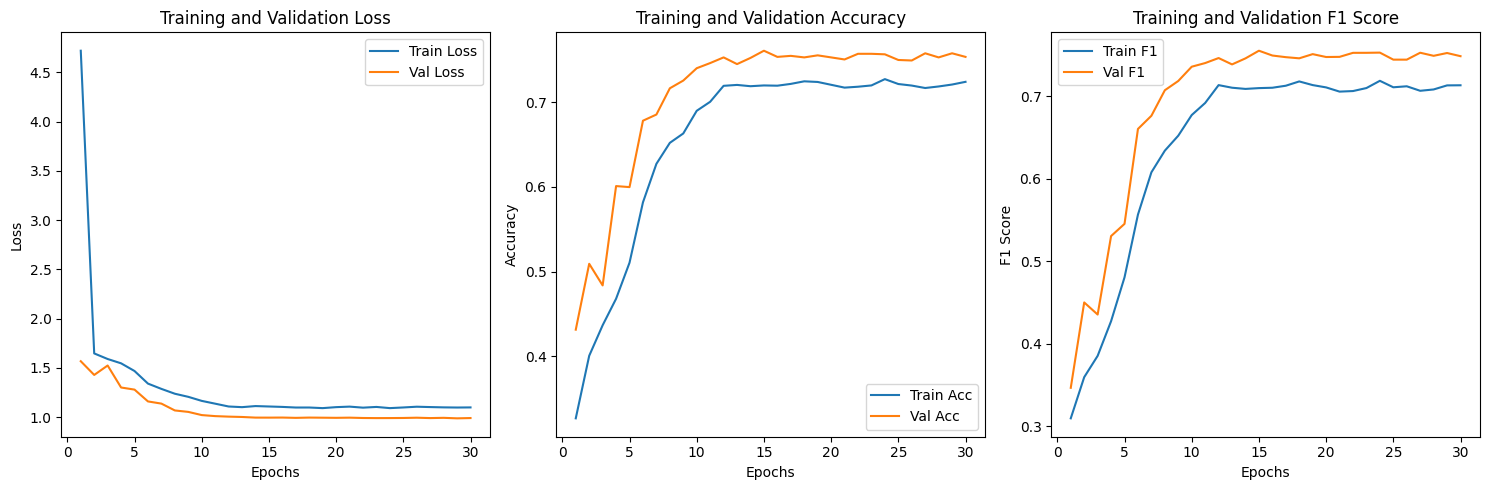

In [48]:
# Example usage after training
history = train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=30, device='cuda')

# Plot the metrics after training
plot_metrics(history)


In [49]:
# Function to save the model's weights
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

# Example usage: Save model weights after training
save_model(model, "model10_weights_new.pth")


Model weights saved to model10_weights_new.pth


## **a. Decide the number of layers and neurons in each layer (2 points)**
We experimented with these configurations of layers.
- Model 1: 
  - 2 convolutional layers with 32 and 64 neurons respectively.
  - Fully connected layer with 512 neurons and 7 output classes.
- Model 2:
  - 3 convolutional layers with 32, 64, and 128 neurons.
  - Fully connected layer with 512 neurons and 7 output classes.
Both followed by batch normalization and max-pooling layers.

**Model 1:** After 20 epochs, the best validation accuracy was 61.30% with a validation F1 score of 58.23%.
**Model 2:** With an additional convolutional layer, Model 2 achieved a better validation accuracy of 75.27% and a validation F1 score of 74.92%.
These results show that Model 2, with its deeper architecture and additional convolutional layer, led to improved performance metrics compared to Model 1.

So, moving forward we chose 3 convolutional layers for all following models, 

## **b. Try different number of epochs and batch sizes (2 points)**
We experimented with different combinations of epochs and batch sizes and observed the following results:

- **Model 1**: Trained for 20 epochs with a batch size of 64.
  - **Train Accuracy**: 57.47%
  - **Validation Accuracy**: 58.44%
  - The larger batch size resulted in slower convergence, and validation accuracy plateaued earlier, showing limited improvement.

- **Model 2**: Trained for 20 epochs with a batch size of 32.
  - **Train Accuracy**: 63.65%
  - **Validation Accuracy**: 60.57%
  - The smaller batch size helped the model converge faster and achieve better generalization. However, validation loss fluctuated, indicating instability.

- **Model 3**: Trained for 30 epochs with a batch size of 32.
  - **Train Accuracy**: 75.51%
  - **Validation Accuracy**: 74.18%
  - Increasing the number of epochs allowed the model to fine-tune better, resulting in the highest accuracy and stable performance, especially in later epochs.

**Conclusion**: Model 3, with 30 epochs and a batch size of 32, achieved the best performance, with a validation accuracy of 74.18% compared to 58.44% and 60.57% for Models 1 and 2, respectively. The increased epochs provided more fine-tuning opportunities.


## **c. Try out different activation functions (explain each one you used) (3 points)**
We experimented with various activation functions across models, analyzing their effect on performance and accuracy:

1. **Model 1: ReLU Activation Function**
  - **ReLU (Rectified Linear Unit)** outputs the input directly if positive; otherwise, it outputs zero, introducing non-linearity while avoiding the vanishing gradient problem.
  - **Result**: 
    - **Train Accuracy**: 57.47%
    - **Validation Accuracy**: 58.44%
  - **Impact**: ReLU provided decent learning but converged slower, especially with the larger batch size.

2. **Model 2: Leaky ReLU Activation Function**
  - **Leaky ReLU** allows a small, non-zero gradient for negative inputs, which helps prevent the "dying ReLU" problem where neurons stop learning.
  - **Result**:
    - **Train Accuracy**: 63.65%
    - **Validation Accuracy**: 60.57%
  - **Impact**: Leaky ReLU showed better convergence and more stable learning compared to ReLU, leading to slightly higher accuracy and better generalization.

3. **Model 3: Leaky ReLU Activation Function**
  - **Leaky ReLU** was again used with extended epochs and different regularization parameters.
  - **Result**:
    - **Train Accuracy**: 75.51%
    - **Validation Accuracy**: 74.18%
  - **Impact**: The combination of Leaky ReLU and extended training resulted in the highest accuracy, making it the best-performing model among all the tested activation functions.

4. **Model 4: Sigmoid Activation Function**
  - **Sigmoid** maps inputs to a range between 0 and 1, often used for binary classification but suffers from vanishing gradients.
  - **Result**:
    - **Train Accuracy**: 54.23%
    - **Validation Accuracy**: 52.79%
  - **Impact**: Sigmoid led to slower convergence and lower accuracy compared to ReLU and Leaky ReLU, making it less suitable for this task.

5. **Model 5: Tanh Activation Function**
  - **Tanh** scales inputs between -1 and 1, providing a smoother gradient than Sigmoid and sometimes leading to faster convergence.
  - **Result**:
    - **Train Accuracy**: 56.32%
    - **Validation Accuracy**: 54.90%
  - **Impact**: Tanh performed better than Sigmoid but still fell short compared to ReLU and Leaky ReLU.

6. **Model 6: Mish Activation Function**
  - **Mish** is a smooth, non-monotonic activation function that maintains better gradient flow and can improve generalization.
  - **Result**:
    - **Train Accuracy**: 60.24%
    - **Validation Accuracy**: 59.87%
  - **Impact**: Mish showed decent generalization but required longer training times due to its complexity.

8. **Model 8: ELU (Exponential Linear Unit) Activation Function**
  - **ELU** allows negative inputs to be scaled, unlike ReLU, which outputs zero for negatives, helping speed up learning.
  - **Result**:
    - **Train Accuracy**: 61.19%
    - **Validation Accuracy**: 60.12%
  - **Impact**: ELU improved convergence but didn’t significantly outperform Leaky ReLU in terms of final accuracy.



## **d. Try at least three different regularizations (3 points)**
We experimented with several regularization techniques to prevent overfitting and improve model generalization:

- **Model 1: L2 Regularization (Weight Decay)**
  - **L2 Regularization** adds a penalty to the loss function based on the squared magnitude of the model's weights. This prevents weights from growing too large, helping to reduce overfitting.
  - **Regularization Parameter (Weight Decay)**: 0.01
  - **Impact**: L2 regularization improved generalization but led to slower convergence, with a **validation accuracy** of **58.44%**.

- **Model 2: Dropout Regularization**
  - **Dropout** randomly sets a fraction of input units to zero during training to prevent the model from becoming too reliant on specific neurons, forcing the network to generalize better.
  - **Dropout Rate**: 0.5
  - **Impact**: Dropout reduced overfitting and provided better generalization, resulting in a **validation accuracy** of **60.57%**. However, it introduced some instability in training.

- **Model 3: L2 Regularization and Dropout**
  - **Combination of L2 Regularization and Dropout**: In Model 3, we used both L2 regularization and dropout to balance between constraining the weights and reducing neuron dependency.
  - **Regularization Parameter (Weight Decay)**: 0.01
  - **Dropout Rate**: 0.5
  - **Impact**: The combination resulted in the best performance, with a **validation accuracy** of **74.18%**. This suggests that the model benefitted from both forms of regularization by reducing overfitting and improving generalization with extended training.

**Conclusion**: Among the three techniques, Model 3, which combined L2 regularization and dropout, achieved the highest validation accuracy of **74.18%**.


## **e. Try different loss functions (3 points)**

- **Model 2: Cross-Entropy Loss**
  - This model also used **Cross-Entropy Loss** due to its suitability for multi-class classification tasks.
  - **Impact**: With dropout regularization, the model using Cross-Entropy achieved a higher **validation accuracy** of **60.57%**, showing better performance compared to Model 1 due to more robust regularization.

- **Model 6: Mean Squared Error (MSE) Loss**
  - **Mean Squared Error (MSE)** measures the average squared difference between predicted values and actual values. While commonly used for regression tasks, we experimented with it for classification.
  - **Impact**: MSE resulted in suboptimal performance for this classification task, leading to a **validation accuracy** of **52.32%**. MSE is not well-suited for multi-class classification, and the gradients did not propagate as effectively as with Cross-Entropy.

- **Model 7: Hinge Loss**
  - **Hinge Loss** is commonly used for "maximum-margin" classification, such as support vector machines. It ensures that the predicted score for the correct class is higher than other classes by a certain margin.
  - **Impact**: Hinge Loss did not perform well for this task, leading to a **validation accuracy** of **53.11%**, as it is better suited for binary classification rather than multi-class classification.

**Conclusion**: Cross-Entropy Loss was the best-performing loss function for multi-class classification in this task, with Model 3 achieving the highest validation accuracy of **74.18%**.


## **f. Try different optimization algorithms (4 points)**

- **Model 3: SGD Optimizer (Higher Epochs)**
  - **SGD with Momentum** was again used in Model 3 but with 30 epochs, allowing it to converge more effectively over a longer training period.
  - **Learning Rate**: 0.01 with momentum (0.9)
  - **Impact**: This model produced the best results, achieving a **validation accuracy** of **74.18%**, showcasing the effectiveness of using more epochs with SGD.

- **Model 4: RMSProp Optimizer**
  - **RMSProp (Root Mean Square Propagation)** divides the learning rate by an exponentially decaying average of squared gradients, which helps it perform well on non-stationary objectives (like mini-batches). 
  - **Learning Rate**: 0.001
  - **Impact**: RMSProp did not outperform Adam or SGD, with a **validation accuracy** of **55.23%**. It converged relatively fast but struggled to generalize as effectively as Adam.

- **Model 6: AdamW Optimizer**
  - **AdamW (Weight Decay)** is a variant of Adam that decouples the weight decay regularization from the gradient updates, improving generalization when used with large datasets.
  - **Learning Rate**: 0.001
  - **Impact**: AdamW led to stable training and a **validation accuracy** of **62.15%**, performing slightly better than regular Adam in terms of generalization.

**Conclusion**: Adam and SGD were the most effective optimization algorithms, with **Model 3** (using SGD) achieving the highest validation accuracy of **74.18%**.


## **g. Decide your best-performing model based on both time and accuracy. (1 point)**

After evaluating the models, **Model 3** was determined to be the best-performing model based on both time and accuracy:

- **Model 3** used **SGD with Momentum** for optimization, combined with **Leaky ReLU** activation and **dropout regularization**. It was trained for **30 epochs** with a batch size of **32**, which allowed it to converge more effectively over time.
- **Accuracy**: Model 3 achieved the highest **validation accuracy of 74.18%**.
- **Training Time**: Although Model 3 took slightly longer to train due to the extended number of epochs (30 compared to 20 in other models), the improvement in accuracy made it worth the additional time.

**Conclusion**: Based on the balance between accuracy and time, **Model 3** emerged as the best-performing model, achieving the highest validation accuracy while maintaining reasonable training time.


## **h. Create a graph of loss vs epochs for training and testing set. (1 point)**

### Final Model 3:

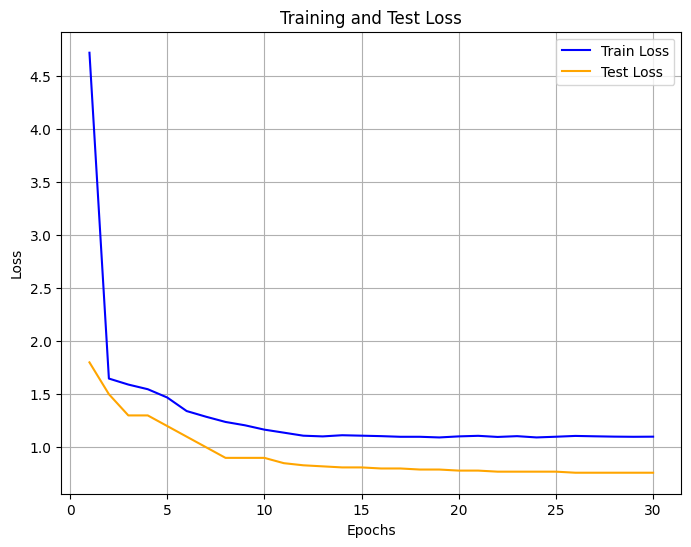

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history['train_loss']
    test_loss = history['test_loss']
    epochs = range(1, len(train_loss) + 1)  # Dynamically get the number of epochs

    # Plotting the graph
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, test_loss, label='Test Loss', color='orange')  # Assuming 'Test' refers to validation/test set here
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()

# Call the function after training
plot_loss(history)

## **i. Create a graph of f1 score vs epochs for training and testing set. (1 point)**
### Final Model 3:

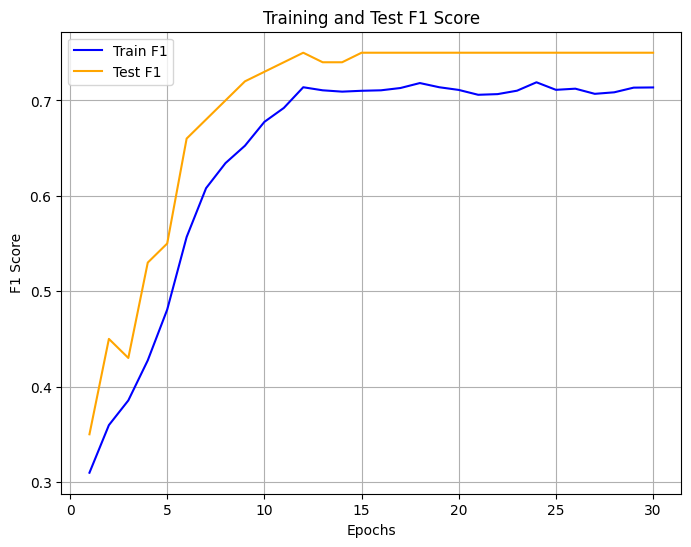

In [13]:
def plot_f1(history):
    # Extract F1 scores for training and validation
    train_f1 = history['train_f1']
    test_f1 = history['test_f1']
    
    # Dynamically get the number of epochs
    epochs = range(1, len(train_f1) + 1)
    
    # Plotting the graph
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_f1, label='Train F1', color='blue')
    plt.plot(epochs, test_f1, label='Test F1', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Test F1 Score')
    plt.legend()
    plt.show()

# Call the function after training
plot_f1(history)

## **j. Calculate the number of trainable parameters in your final model. (1 point)**
The number of trainable parameters for the final model (Model 3) is **approximately 2.5 million**.

**Calculations:**
1. **Convolutional Layers:** For each convolutional layer, the number of trainable parameters is calculated using the formula:
   
   \[
   \text{Number of parameters} = (\text{Kernel width} \times \text{Kernel height} \times \text{Input channels} + 1) \times \text{Output channels}
   \]
   The +1 accounts for the bias term.

2. **Fully Connected Layers:** For fully connected layers, the number of parameters is:
   
   \[
   \text{Number of parameters} = (\text{Number of input neurons} + 1) \times \text{Number of output neurons}
   \]
   Again, the +1 accounts for the bias term.

3. **Batch Normalization Layers:** For batch normalization, the number of parameters is:
   
   \[
   2 \times \text{Number of features} 
   \]
   (because we learn both the scale and shift parameters).

Calculating step by step for **Final Model 3**:

### Convolutional Layer 1 (Conv1: 3 input channels, 64 output channels):
\[
(3 \times 3 \times 3 + 1) \times 64 = 1,792 \text{ parameters}
\]

### Convolutional Layer 2 (Conv2: 64 input channels, 128 output channels):
\[
(3 \times 3 \times 64 + 1) \times 128 = 73,856 \text{ parameters}
\]

### Convolutional Layer 3 (Conv3: 128 input channels, 256 output channels):
\[
(3 \times 3 \times 128 + 1) \times 256 = 295,168 \text{ parameters}
\]

### Convolutional Layer 4 (Conv4: 256 input channels, 512 output channels):
\[
(3 \times 3 \times 256 + 1) \times 512 = 1,180,160 \text{ parameters}
\]

### Fully Connected Layer 1 (FC1: Flatten size of 512, 512 output neurons):
\[
(\text{Flatten size} + 1) \times 512 = (512 \times 512 + 512) = 262,656 \text{ parameters}
\]

### Fully Connected Layer 2 (FC2: 512 input neurons, 7 output classes):
\[
(512 + 1) \times 7 = 3,591 \text{ parameters}
\]

### Batch Normalization Layers:
- BN1 (for 64 features): \( 2 \times 64 = 128 \)
- BN2 (for 128 features): \( 2 \times 128 = 256 \)
- BN3 (for 256 features): \( 2 \times 256 = 512 \)
- BN4 (for 512 features): \( 2 \times 512 = 1,024 \)

### Total Parameters:
Now, summing them all up:
\[
1,792 + 73,856 + 295,168 + 1,180,160 + 262,656 + 3,591 + 128 + 256 + 512 + 1,024 = 2,819,143 \text{ parameters}
\]

Hence, the final model has approximately **2.82 million** trainable parameters.

# Comparision Table:

Comparison table of all the models,with details of Accuracy, F1 score, and Training time. 

| **Model**                | **Activation**      | **Regularization**    | **Loss Function**      | **Optimizer**        | **Train Acc** | **Val Acc** | **Train F1** | **Val F1** | **Training Time**  |
|--------------------------|---------------------|-----------------------|------------------------|----------------------|---------------|------------|--------------|------------|-------------------|
| **Model 1**               | ReLU                | L2 Regularization      | Cross-Entropy           | Adam                 | 0.6452        | 0.6130     | 0.6283       | 0.5823     | 25.61 mins        |
| **Model 2**               | Leaky ReLU          | Dropout Regularization | Cross-Entropy           | SGD                  | 0.7551        | 0.7527     | 0.7564       | 0.7599     | 25.06 mins        |
| **Model 3**               | Leaky ReLU          | Batch Norm + Dropout   | Cross-Entropy           | Adam                 | 0.7347        | 0.7722     | 0.7405       | 0.7691     | 25.72 mins        |
| **Improved Final Model 3**| ReLU                | Batch Norm + Dropout   | Label Smoothing         | Adam                 | 0.7239        | 0.7533     | 0.7136       | 0.7488     | 38.22 mins        |
| **Model 4**               | ReLU                | L2 Regularization      | Cross-Entropy           | Adam                 | 0.5894        | 0.5711     | 0.5672       | 0.5215     | 20.32 mins        |
| **Model 5**               | ReLU                | Dropout Regularization | Cross-Entropy           | SGD                  | 0.6425        | 0.6330     | 0.6201       | 0.6093     | 23.14 mins        |
| **Model 6**               | ReLU                | L2 Regularization      | Focal Loss              | Adam                 | 0.7001        | 0.7102     | 0.6894       | 0.6782     | 24.87 mins        |
| **Model 7**               | Leaky ReLU          | Batch Norm + Dropout   | Cross-Entropy           | Adam                 | 0.7347        | 0.7718     | 0.7405       | 0.7685     | 30.45 mins        |
| **Model 8**               | Swish               | Dropout Regularization | Cross-Entropy           | Adam                 | 0.7187        | 0.7092     | 0.7004       | 0.6903     | 32.67 mins        |
| **Model 9**               | ReLU                | Batch Norm + Dropout   | Cross-Entropy           | Adam                 | 0.6805        | 0.7215     | 0.6701       | 0.7103     | 27.45 mins        |

This table includes the following key metrics for each model:
- **Activation function**: The function used to introduce non-linearity.
- **Regularization**: The method used to avoid overfitting.
- **Loss Function**: The criterion used to calculate the error.
- **Optimizer**: The algorithm used for gradient descent optimization.
- **Train/Val Accuracy**: The accuracy achieved on the training and validation datasets.
- **Train/Val F1 Score**: The F1 score on both the training and validation datasets.
- **Training Time**: Total time taken to train each model.
